In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from groupby_imputer import GroupbyImputer

Let's take a look at the dataset

In [13]:
df = pd.read_csv('/content/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [14]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Suppose we'll fill the missing values in the `ceiling_height` column

In [15]:
df['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

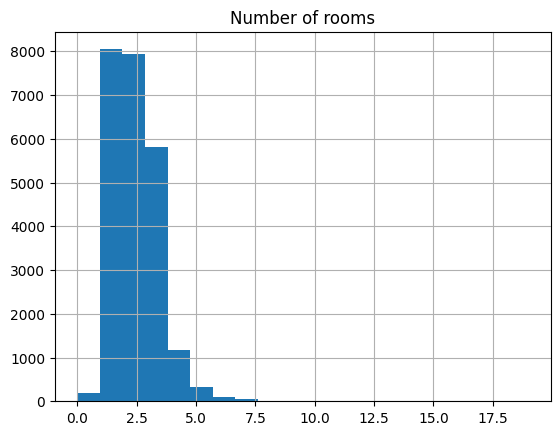

In [16]:
df['rooms'].hist(bins=20)
plt.title('Number of rooms');

In [17]:
df = df[df['rooms'] <= 5]

In [18]:
df['rooms'] = df['rooms'].astype('category')

Unique values in `rooms` column are not too numerous - that's what I'm looking for. Let's treat this feature as categorial for testing purposes (there's no true categorial features in the dataset). Not many flats have more than 5 rooms - so I dropped those.

The imputer takes as input the names of A) `column_to_fill`,  B) `groupby_column`, number of groups we wish (default is 4) and the aggregation function (default is median). The latter two are not obligatory. For grouping by categories we don't need the number of groups - it equals the number of unique categories in the column

In [22]:
pipe = Pipeline(
    steps=[
        ('imputer', GroupbyImputer('ceiling_height', 'rooms'))
    ]
)

trans_df_cat = pipe.fit_transform(df)

trans_df_cat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.64,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.60,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


It works. Rows 1, 2 and 3 are filled regarding their number of rooms. Let's try numeric feature, say, total number of floors

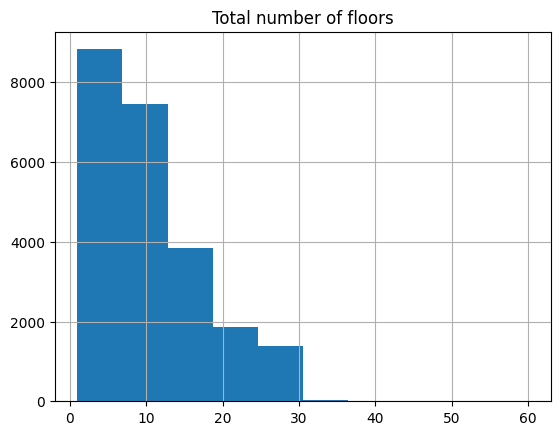

In [20]:
df['floors_total'].hist()
plt.title('Total number of floors');

In [21]:
df = df[df['floors_total'] <=30]

I just dropped the cases in buildings higher than 30 floors - there're not really many of them

In [23]:
pipe = Pipeline(
    steps=[
        ('imputer', GroupbyImputer('ceiling_height', 'floors_total', num_groups=6))
    ]
)

trans_df_num = pipe.fit_transform(df)

trans_df_num.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,groups
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,"(15.0, 19.667]"
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,"(10.333, 15.0]"
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.60,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,"(0.972, 5.667]"
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,"(10.333, 15.0]"
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,"(10.333, 15.0]"


NaN's are filled now in accordance with the total number of floors in the building. 11 and 14 floors (rows 1 and 3) belong to the same group, with median = 2.65, and 5 floors (row 2) to another, with median = 2.60

We can try another aggfunc

In [24]:
pipe = Pipeline(
    steps=[
        ('imputer', GroupbyImputer('ceiling_height', 'floors_total', num_groups=6, aggfunc='max'))
    ]
)

trans_df_num = pipe.fit_transform(df)

trans_df_num.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,groups
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,"(15.0, 19.667]"
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,22.60,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,"(10.333, 15.0]"
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,100.00,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,"(0.972, 5.667]"
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,22.60,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,"(10.333, 15.0]"
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,"(10.333, 15.0]"


Well, looks inadequate - but that's due to the outliers in the dataset. The imputer does its job well